# *The missing Link:*
# CAS Applied Data Science Final Project
# Matthias Rinderknecht

# Notebook 5: Analyse merged dataframes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from collections import defaultdict

### Analyse the saved merged file from Notebook 2 (linktransformer) or 4 (Faiss) for number and percentage of matches between whoId and trialId

For k=1 (top matching), enter "1" as the k-value, for k=3, enter "3"

In [42]:
# Load CSV file into a pd DataFrame
file_path = "/Users/marinder/Documents/CAS_ADS/Final Project/Merges/matched_file_match84.csv"
df = pd.read_csv(file_path)

# Count number of rows in input CSV
num_rows = len(df)
print (num_rows)

# Count unique snctpIds in input CSV
num_unique_snctpIds = df['snctpId'].nunique()
print (num_unique_snctpIds)

# Ask the user for the k-value
k = int(input("Enter k-value: "))

# Add the "Rang" column to the DataFrame
rang_values = []
current_rang = 1
for i in range(len(df)):
    rang_values.append(current_rang)
    current_rang += 1
    if current_rang > k:
        current_rang = 1

df['Rang'] = rang_values
#print (rang_values)

# Create a defaultdict to store the count of matches for each "Rang" group
rang_matches = defaultdict(int)

# Iterate through each unique snctpId
for snctpId in df['snctpId'].unique():
    # Get rows for the current snctpId
    snctpId_rows = df[df['snctpId'] == snctpId]
    # Sort the rows by 'Rang' in ascending order
    snctpId_rows = snctpId_rows.sort_values(by='Rang')
    # Initialize a flag to track if a match is found for this snctpId
    match_found = False
    # Iterate through rows for the current snctpId
    for index, row in snctpId_rows.iterrows():
        # Check if there's a match between 'whoId' and 'trialId'
        if row['whoId'] == row['trialId']:
            # Record the match and the Rang group
            rang_matches[row['Rang']] += 1
            # Set the flag to True to indicate a match is found for this snctpId
            match_found = True
            # Break out of the loop since we only need to record one match per snctpId
            break
    # If no match is found for this snctpId, record it as a match in Rang 0
    #if not match_found:
        #rang_matches[0] += 1

# Calculate the overall number of matches
overall_matches = sum(rang_matches.values())

# Calculate the overall percentage of matches
#overall_percentage = (overall_matches / num_unique_snctpIds) * 100
overall_percentage = (overall_matches / num_unique_snctpIds) * 100


# Display overall statistics
print("Overall Statistics:")
print("Total Rows in CSV:", num_rows)
print("Number of Unique snctpIds in CSV:", num_unique_snctpIds)
print("Total Matches in All Rang Groups:", overall_matches)
print("Overall Percentage of Matches:", overall_percentage)

# Display results per Rang group
print("\nResults for Each Rang Group:")
results = []
for rang in range(1, k + 1):
    count = rang_matches[rang]
    total_rows = len(df[df['Rang'] == rang])
    if total_rows != 0:
        percentage = (count / num_unique_snctpIds) * 100
    else:
        percentage = 0
    results.append({'Rang': rang, 'Total Rows': num_rows, 'Matches': count, 'Percentage': percentage})

results_df = pd.DataFrame(results)
print(results_df)


9162
3054
Enter k-value: 3
Overall Statistics:
Total Rows in CSV: 9162
Number of Unique snctpIds in CSV: 3054
Total Matches in All Rang Groups: 2827
Overall Percentage of Matches: 92.56712508185986

Results for Each Rang Group:
   Rang  Total Rows  Matches  Percentage
0     1        9162     2552   83.562541
1     2        9162      210    6.876228
2     3        9162       65    2.128356


### Analyse manually adjudicated merged files for matches within bins

Number of non-null rows in df: 100
    score_bin  total_rows  matches  percent_matches
0  [0.4, 0.5)         1.0      0.0             0.00
1  [0.5, 0.6)         8.0      0.0             0.00
2  [0.6, 0.7)        23.0      2.0             8.70
3  [0.7, 0.8)        25.0     14.0            56.00
4  [0.8, 0.9)        31.0     28.0            90.32
5  [0.9, 1.0)        12.0     12.0           100.00


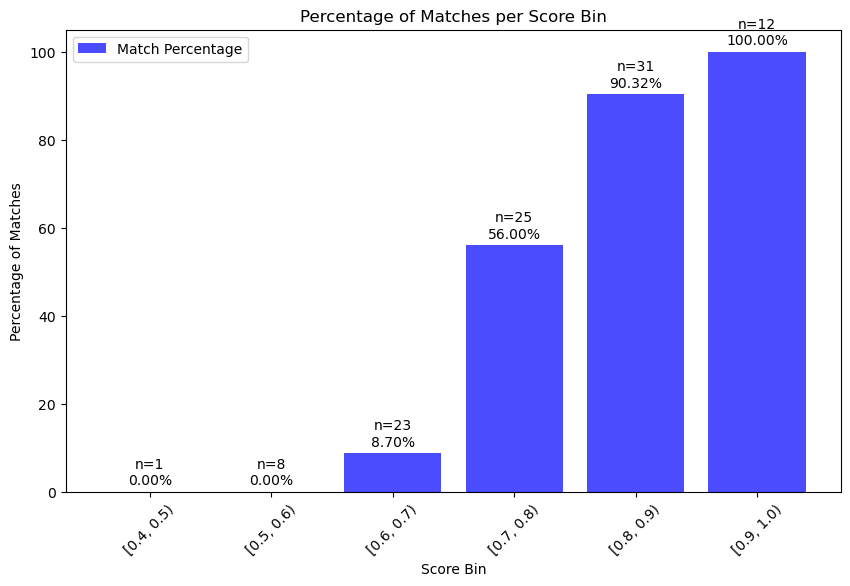

In [20]:
# Read the CSV file into a pandas dataframe
df = pd.read_csv('/Users/marinder/Documents/CAS_ADS/Final Project/Merges/matched_file_match65_test.csv')

# Extract rows with non-null values in the "Match?" column into a new dataframe
non_null_df = df.dropna(subset=['Match?'])

# Print number of rows in the new dataframe
print("Number of non-null rows in df:", len(non_null_df))

# Define a function to count matches and calculate the percentage of matches
def count_matches(group):
    total_rows = group.shape[0]
    ones = group['Match?'].sum()
    percent_matches = ((ones / total_rows) * 100).round(2) if total_rows > 0 else 0
    return pd.Series([int(total_rows), ones, percent_matches], index=['total_rows', 'matches', 'percent_matches'])

# Group by score_bin and apply the count_matches function
result = non_null_df.groupby('score_bin').apply(count_matches).reset_index()

# Print the result
print(result)

# Plot histogram with percentage of matches and n's annotated
plt.figure(figsize=(10, 6))
bars = plt.bar(result['score_bin'], result['percent_matches'], color='blue', alpha=0.7, label='Match Percentage')
plt.xlabel('Score Bin')
plt.ylabel('Percentage of Matches')
plt.title('Percentage of Matches per Score Bin')
plt.xticks(rotation=45)
plt.legend()

# Annotate bars with percentage and n's
for bar, n, percent in zip(bars, result['total_rows'], result['percent_matches']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'n={int(n)}\n{percent:.2f}%', ha='center', va='bottom', color='black')

plt.show()

### Plot the Receiver Operating Curve to determine optimal confidence score threshold

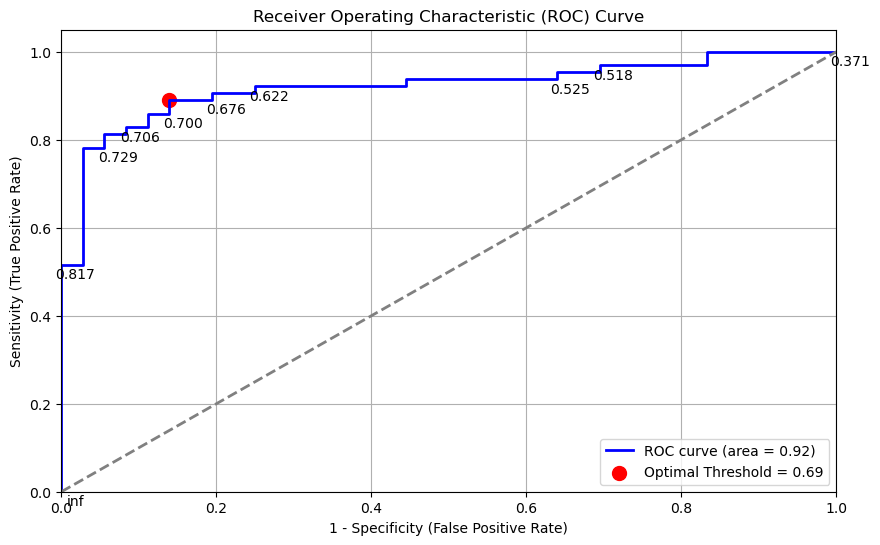

The optimal threshold is 0.69
The sensitivity at this threshold is 0.89
The false positive rate at this threshold is 0.14
The number of reported true positives at this threshold is 57 out of 64 true positives in total
The number of reported false positives at this threshold is 5
The total number of rows making it above the optimal threshold is: 62


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

# Read the CSV file into a pandas dataframe
df = pd.read_csv('/Users/marinder/Documents/CAS_ADS/Final Project/Merges/FAISS/result_1.csv')

# Drop rows where 'Match?' column is NaN
df = df.dropna(subset=['Match?'])

# Ensure that the 'Match?' column is binary (0 or 1)
df['Match?'] = df['Match?'].astype(int)

# Extract the true labels and scores
y_true = df['Match?']
y_scores = df['score']

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate the distances to the top-left corner (0, 1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_index = np.argmin(distances)
optimal_threshold = thresholds[optimal_index]
optimal_sensitivity = tpr[optimal_index]  # Sensitivity at the optimal threshold
optimal_specificity = 1 - fpr[optimal_index]  # Specificity at the optimal threshold

num_above_threshold = sum(y_scores >= optimal_threshold)

# Get the number of true positives and false positives at the optimal threshold
y_pred = (y_scores >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Select 10 threshold values evenly spaced
num_thresholds = 10
threshold_indices = np.linspace(0, len(thresholds) - 1, num_thresholds, dtype=int)
selected_thresholds = thresholds[threshold_indices]

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[optimal_index], tpr[optimal_index], color='red', marker='o', s=100, label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Annotate the selected threshold values
for i in threshold_indices:
    threshold = thresholds[i]
    plt.annotate(f'{threshold:.3f}', 
                 (fpr[i], tpr[i]), 
                 textcoords="offset points", 
                 xytext=(10,-10), 
                 ha='center')

plt.show()

# Print the optimal threshold, sensitivity, specificity, true positives, and false positives
print(f'The optimal threshold is {optimal_threshold:.2f}')
print(f'The sensitivity at this threshold is {optimal_sensitivity:.2f}')
print(f'The false positive rate at this threshold is {1-optimal_specificity:.2f}')
print(f'The number of reported true positives at this threshold is {tp} out of {tp+fn} true positives in total')
print(f'The number of reported false positives at this threshold is {fp}')
print(f"The total number of rows making it above the optimal threshold is: {num_above_threshold}")

### Calculate predicted metrics for full 1535 query set based on metrics obtained in the 100 query adjudicated sample

In [26]:
THRESHOLD = 0.69
SENSITIVITY = 0.89
FPR = .14

PPV = 57/62
FDR = 1-PPV

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/Users/marinder/Documents/CAS_ADS/Final Project/Merges/FAISS/result_1.csv')
    
# Get the initial number of rows
initial_rows = len(df)
    
# Drop rows where the score is below the threshold
df = df[df['score'] >= THRESHOLD]
    
# Get the number of remaining rows
remaining_rows = len(df)
    
# Calculate the percentage of remaining rows
remaining_percentage = (remaining_rows / initial_rows) * 100

max_rows = remaining_rows/(62/64)
    
# Print the results
print(f"Initial number of rows: {initial_rows}")
print(f"Predicted number of maximally achievable matches: {initial_rows*.64:.0f}")
print(f"Remaining number and percentage of rows above threshold: {remaining_rows}, {remaining_percentage:.1f}%")
#print(f"Predicted correct matches remaining above threshold: {(1-FPR)*remaining_rows:.0f}")
#print(f"Predicted correct matches remaining above threshold: {SENSITIVITY*max_rows:.0f}")
print(f"Predicted correct matches remaining above threshold: {PPV*remaining_rows:.0f}, {(PPV*remaining_rows)/(initial_rows*.64)*100:.1f}%")
print(f"Missed true matches below threshold: {(initial_rows*.64)-(PPV*remaining_rows):.0f}")
print(f"Predicted false positives above threshold: {remaining_rows*FDR:.0f}")
print(f"Rate of correct matches over false positives above threshold: {(PPV/FDR):.2f}")

Initial number of rows: 1535
Predicted number of maximally achievable matches: 982
Remaining number and percentage of rows above threshold: 785, 51.1%
Predicted correct matches remaining above threshold: 722, 73.5%
Missed true matches below threshold: 261
Predicted false positives above threshold: 63
Rate of correct matches over false positives above threshold: 11.40
